Importing Libraries

In [1]:
!pip install optuna
!pip install optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.6 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, make_scorer)
import xgboost as xgb
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import optuna
from optuna.integration import TFKerasPruningCallback
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



print("Libraries imported successfully!")

Libraries imported successfully!


Data set

In [3]:
!wget -O /content/Data https://www.dropbox.com/scl/fi/e9hikepsn21u207qhiit0/dataset.csv?rlkey=msrqmse26sio93bwpgopyp49s&st=gphpu32s&dl=0

df = pd.read_csv('/content/Data')
df

--2025-10-16 11:23:25--  https://www.dropbox.com/scl/fi/e9hikepsn21u207qhiit0/dataset.csv?rlkey=msrqmse26sio93bwpgopyp49s
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04700ef909c8c5ebc153c64b80.dl.dropboxusercontent.com/cd/0/inline/CzUueUf3MxmONMIxgdFI2ClJ3kyKQcRBQJbvbHnodkJaU_45T8AMVPtARCCqOvy5i1Psz0-UBiwws-NPq7EGF9gw-uDKOgUY21KXpw5i4WJbtiJQTjt7y9Q44ccs6asjUblI-l-N-53m59bRhFRAk8J-/file# [following]
--2025-10-16 11:23:26--  https://uc04700ef909c8c5ebc153c64b80.dl.dropboxusercontent.com/cd/0/inline/CzUueUf3MxmONMIxgdFI2ClJ3kyKQcRBQJbvbHnodkJaU_45T8AMVPtARCCqOvy5i1Psz0-UBiwws-NPq7EGF9gw-uDKOgUY21KXpw5i4WJbtiJQTjt7y9Q44ccs6asjUblI-l-N-53m59bRhFRAk8J-/file
Resolving uc04700ef909c8c5ebc153c64b80.dl.dropboxusercontent.com (uc04700ef909c8c5ebc153c64b80.dl.dropboxusercontent.com)... 162.125.6.15, 2620:10

,Customer_ID,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Promotion_Response,Target_Churn
0,1,62,Other,45.15,5892.58,5,22,453.80,2,0,3,129,True,Responded,True
1,2,65,Male,79.51,9025.47,13,77,22.90,2,2,3,227,False,Responded,False
2,3,18,Male,29.19,618.83,13,71,50.53,5,2,2,283,False,Responded,True
3,4,21,Other,79.63,9110.30,3,33,411.83,5,3,5,226,True,Ignored,True
4,5,21,Other,77.66,5390.88,15,43,101.19,3,0,5,242,False,Unsubscribed,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,54,Male,143.72,1089.09,2,29,77.75,0,3,2,88,True,Ignored,False
996,997,19,Male,164.19,3700.24,9,90,34.45,6,4,4,352,False,Responded,True
997,998,47,Female,113.31,705.85,17,69,187.37,7,3,1,172,True,Unsubscribed,False
998,999,23,Male,72.98,3891.60,7,31,483.80,1,2,5,55,False,Responded,True


In [4]:
print("Dataset Overview")

print(f"Dataset Shape: {df.shape}")
print(f"Number of Records: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

print("First Few Records:")
print(df.head())

print("Data Types and Info:")
print(df.info())

print("Statistical Summary:")
print(df.describe())

# 1.1 Identify Key Features
print("\Key Features Identified:")

feature_types = {
    'Numerical': ['Age', 'Annual_Income', 'Total_Spend', 'Years_as_Customer',
                  'Num_of_Purchases', 'Average_Transaction_Amount', 'Num_of_Returns',
                  'Num_of_Support_Contacts', 'Satisfaction_Score', 'Last_Purchase_Days_Ago'],
    'Categorical': ['Gender', 'Email_Opt_In', 'Promotion_Response'],
    'Target': ['Target_Churn']
}

for ftype, features in feature_types.items():
    print(f"\n{ftype} Features ({len(features)}):")
    print(", ".join(features))


Dataset Overview
Dataset Shape: (1000, 15)
Number of Records: 1000
Number of Features: 15
First Few Records:
   Customer_ID  Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
0            1   62  Other          45.15      5892.58                  5   
1            2   65   Male          79.51      9025.47                 13   
2            3   18   Male          29.19       618.83                 13   
3            4   21  Other          79.63      9110.30                  3   
4            5   21  Other          77.66      5390.88                 15   

   Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
0                22                      453.80               2   
1                77                       22.90               2   
2                71                       50.53               5   
3                33                      411.83               5   
4                43                      101.19               3   

   Num_of_Support_Contact

Data Preprocessing

In [ ]:
print("Missing Values Check:")

missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found!")

print("Duplicate Records Check:")

duplicates = df.duplicated().sum()
print(f"Number of duplicate records: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New shape: {df.shape}")

Missing Values Check:
No missing values found!
Duplicate Records Check:
Number of duplicate records: 0


In [18]:
df = df.drop(columns=['Customer_ID'])

Data Visualization

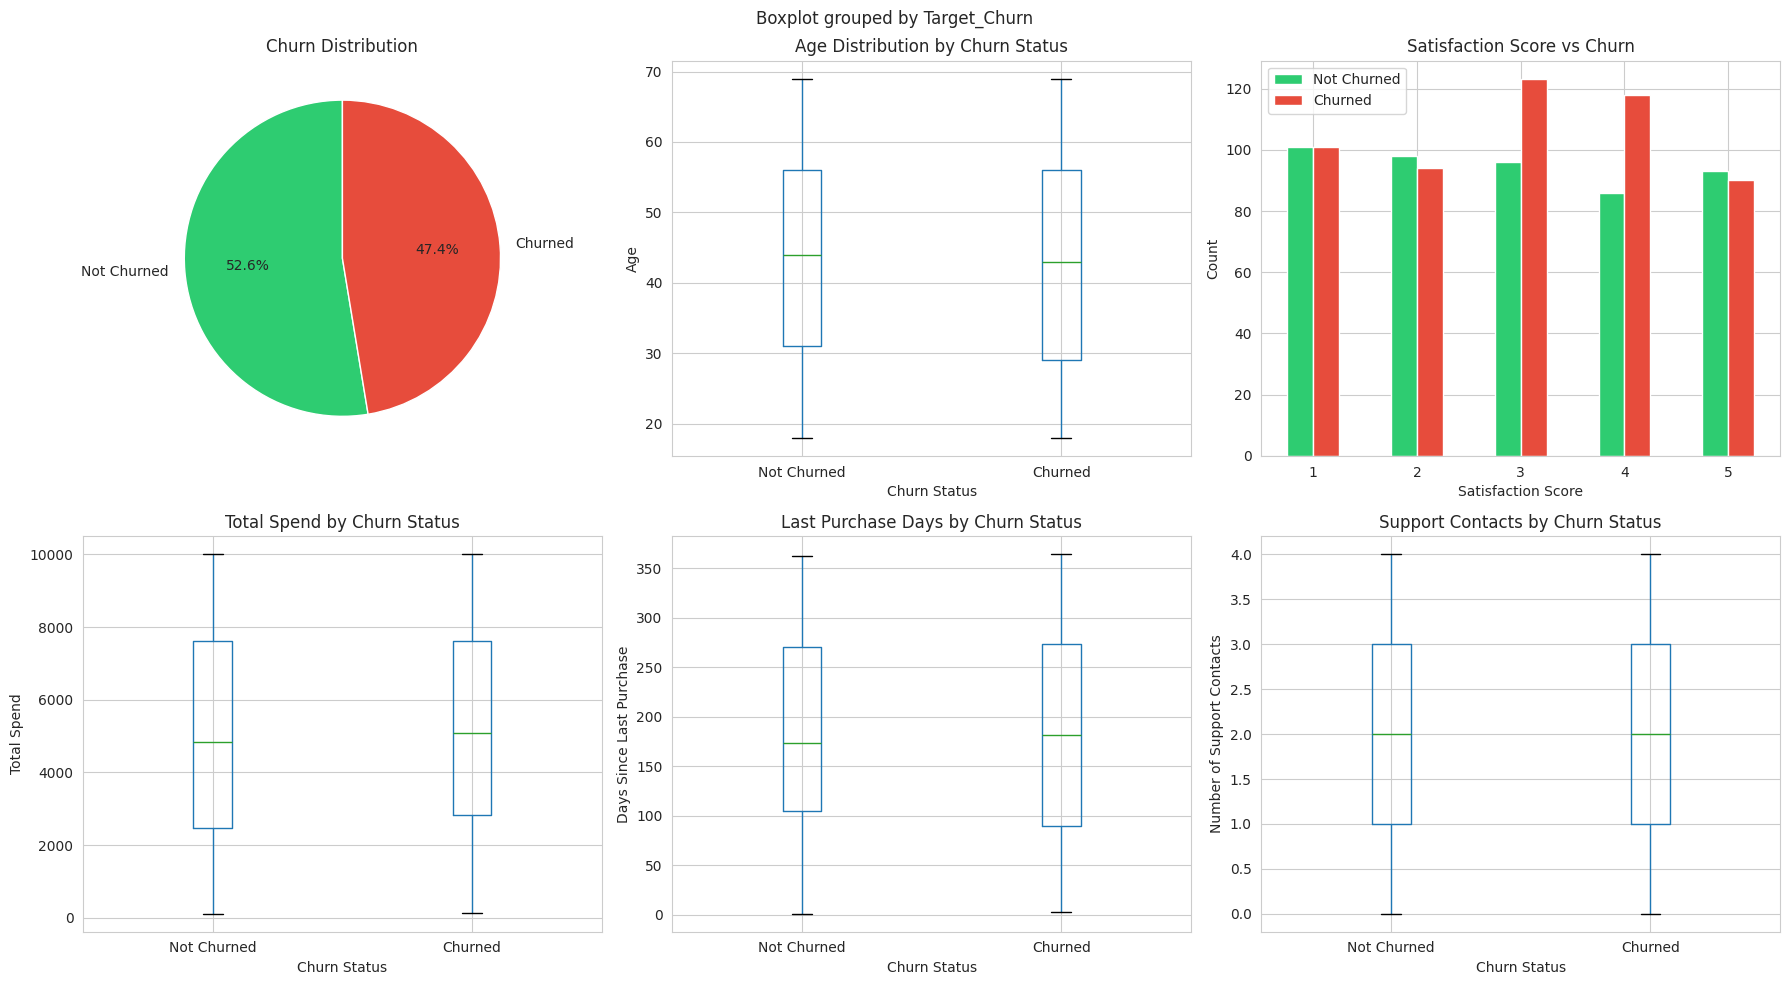

In [19]:
# Target Distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Exploratory Data Analysis - Key Visualizations', fontsize=16, fontweight='bold')

# 1. Target Distribution
churn_counts = df['Target_Churn'].value_counts()
axes[0, 0].pie(churn_counts, labels=['Not Churned', 'Churned'], autopct='%1.1f%%',
               colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[0, 0].set_title('Churn Distribution')

# 2. Age Distribution by Churn
df.boxplot(column='Age', by='Target_Churn', ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Churn Status')
axes[0, 1].set_xlabel('Churn Status')
axes[0, 1].set_ylabel('Age')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Not Churned', 'Churned'])

# 3. Satisfaction Score vs Churn
satisfaction_churn = df.groupby(['Satisfaction_Score', 'Target_Churn']).size().unstack(fill_value=0)
satisfaction_churn.plot(kind='bar', ax=axes[0, 2], color=['#2ecc71', '#e74c3c'])
axes[0, 2].set_title('Satisfaction Score vs Churn')
axes[0, 2].set_xlabel('Satisfaction Score')
axes[0, 2].set_ylabel('Count')
axes[0, 2].legend(['Not Churned', 'Churned'])
axes[0, 2].tick_params(axis='x', rotation=0)

# 4. Total Spend Distribution
df.boxplot(column='Total_Spend', by='Target_Churn', ax=axes[1, 0])
axes[1, 0].set_title('Total Spend by Churn Status')
axes[1, 0].set_xlabel('Churn Status')
axes[1, 0].set_ylabel('Total Spend')
plt.sca(axes[1, 0])
plt.xticks([1, 2], ['Not Churned', 'Churned'])

# 5. Last Purchase Days
df.boxplot(column='Last_Purchase_Days_Ago', by='Target_Churn', ax=axes[1, 1])
axes[1, 1].set_title('Last Purchase Days by Churn Status')
axes[1, 1].set_xlabel('Churn Status')
axes[1, 1].set_ylabel('Days Since Last Purchase')
plt.sca(axes[1, 1])
plt.xticks([1, 2], ['Not Churned', 'Churned'])

# 6. Support Contacts
df.boxplot(column='Num_of_Support_Contacts', by='Target_Churn', ax=axes[1, 2])
axes[1, 2].set_title('Support Contacts by Churn Status')
axes[1, 2].set_xlabel('Churn Status')
axes[1, 2].set_ylabel('Number of Support Contacts')
plt.sca(axes[1, 2])
plt.xticks([1, 2], ['Not Churned', 'Churned'])

plt.tight_layout()
plt.show()

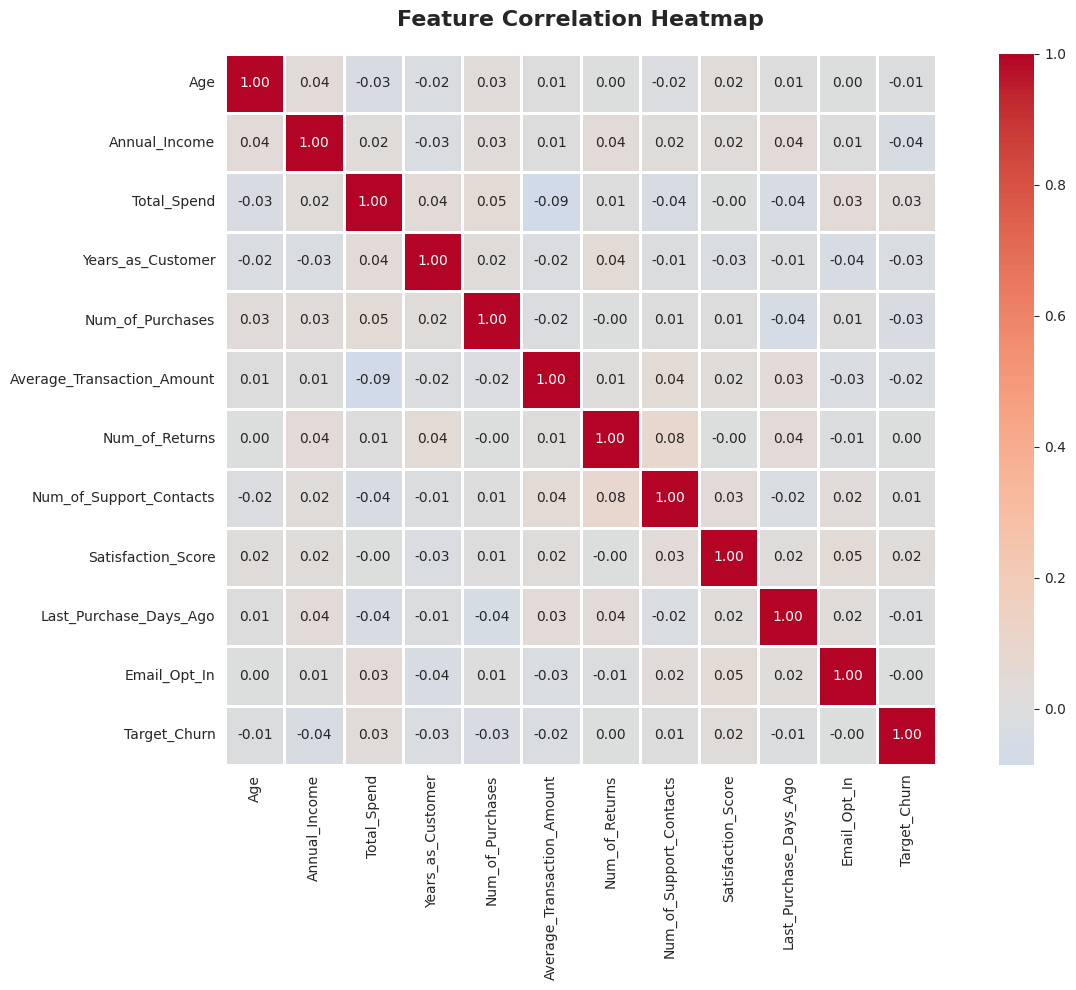

In [20]:
#heatmap generation

plt.figure(figsize=(14, 10))
# Prepare numerical data
df_numeric = df.copy()
df_numeric['Target_Churn'] = df_numeric['Target_Churn'].astype(int)
df_numeric['Email_Opt_In'] = df_numeric['Email_Opt_In'].astype(int)

# Select only numerical columns
numeric_cols = df_numeric.select_dtypes(include=[np.number]).columns
correlation_matrix = df_numeric[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [21]:
# Calculate correlation with target
target_correlation = correlation_matrix['Target_Churn'].drop('Target_Churn').sort_values(ascending=False)
print("\nCorrelation with Churn (Top 10):")
print(target_correlation.abs().sort_values(ascending=False).head(10))


Correlation with Churn (Top 10):
Annual_Income                 0.036322
Num_of_Purchases              0.032772
Years_as_Customer             0.029823
Total_Spend                   0.028659
Average_Transaction_Amount    0.024723
Satisfaction_Score            0.022567
Last_Purchase_Days_Ago        0.013823
Num_of_Support_Contacts       0.009593
Age                           0.009260
Email_Opt_In                  0.001019
Name: Target_Churn, dtype: float64


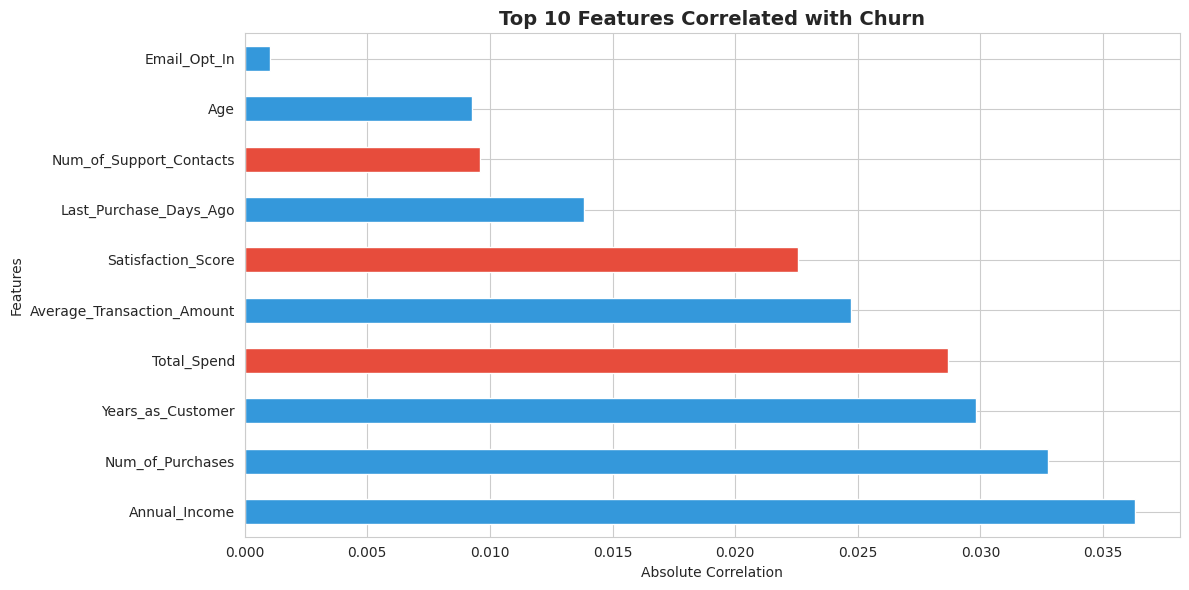

In [22]:
# Visualize top features
plt.figure(figsize=(12, 6))
top_features = target_correlation.abs().sort_values(ascending=False).head(10)
colors = ['#e74c3c' if x > 0 else '#3498db' for x in target_correlation[top_features.index]]
top_features.plot(kind='barh', color=colors)
plt.title('Top 10 Features Correlated with Churn', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

Trend and Patterns

In [23]:
# Pattern 1: Satisfaction Score Analysis
print("\n• Satisfaction Score Impact:")
satisfaction_churn_rate = df.groupby('Satisfaction_Score')['Target_Churn'].mean() * 100
print(satisfaction_churn_rate.to_string())

# Pattern 2: Returns and Churn
print("\n• Returns Analysis:")
returns_stats = df.groupby('Target_Churn')['Num_of_Returns'].agg(['mean', 'median', 'std'])
returns_stats.index = ['Not Churned', 'Churned']
print(returns_stats)

# Pattern 3: Support Contacts
print("\n• Support Contacts Analysis:")
support_stats = df.groupby('Target_Churn')['Num_of_Support_Contacts'].agg(['mean', 'median', 'std'])
support_stats.index = ['Not Churned', 'Churned']
print(support_stats)

# Pattern 4: Recency
print("\n• Purchase Recency Analysis:")
recency_stats = df.groupby('Target_Churn')['Last_Purchase_Days_Ago'].agg(['mean', 'median', 'std'])
recency_stats.index = ['Not Churned', 'Churned']
print(recency_stats)


• Satisfaction Score Impact:
Satisfaction_Score
1    50.000000
2    48.958333
3    56.164384
4    57.843137
5    49.180328

• Returns Analysis:
                 mean  median       std
Not Churned  4.611814     5.0  2.975081
Churned      4.612167     5.0  2.827377

• Support Contacts Analysis:
                 mean  median       std
Not Churned  1.919831     2.0  1.399905
Churned      1.946768     2.0  1.406454

• Purchase Recency Analysis:
                   mean  median         std
Not Churned  184.409283   174.0  102.860017
Churned      181.520913   182.0  105.831342


# Data Preprocessing

In [24]:
# Create a copy for preprocessing
df_processed = df.copy()

print("Encoding Categorical Features")
# Encode Gender
le_gender = LabelEncoder()
df_processed['Gender_Encoded'] = le_gender.fit_transform(df_processed['Gender'])
print(f"Gender encoding: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")

# Encode Promotion_Response
le_promo = LabelEncoder()
df_processed['Promotion_Response_Encoded'] = le_promo.fit_transform(df_processed['Promotion_Response'])
print(f"Promotion Response encoding: {dict(zip(le_promo.classes_, le_promo.transform(le_promo.classes_)))}")

# Encode Email_Opt_In (boolean to binary)
df_processed['Email_Opt_In_Encoded'] = df_processed['Email_Opt_In'].astype(int)

# Encode Target
df_processed['Target_Encoded'] = df_processed['Target_Churn'].astype(int)

# Drop original categorical columns
df_processed = df_processed.drop(['Gender', 'Promotion_Response', 'Email_Opt_In', 'Target_Churn'], axis=1)

print("Feature Selection for Modeling")


# Define features and target
feature_cols = [col for col in df_processed.columns if col != 'Target_Encoded']
X = df_processed[feature_cols]
y = df_processed['Target_Encoded']

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {', '.join(feature_cols)}")


Encoding Categorical Features
Gender encoding: {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
Promotion Response encoding: {'Ignored': np.int64(0), 'Responded': np.int64(1), 'Unsubscribed': np.int64(2)}
Feature Selection for Modeling
Number of features: 13
Features: Age, Annual_Income, Total_Spend, Years_as_Customer, Num_of_Purchases, Average_Transaction_Amount, Num_of_Returns, Num_of_Support_Contacts, Satisfaction_Score, Last_Purchase_Days_Ago, Gender_Encoded, Promotion_Response_Encoded, Email_Opt_In_Encoded


# Train_test Split

In [25]:
# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: separate train and validation (80% train, 20% validation of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining set class distribution:\n{y_train.value_counts()}")
print(f"Validation set class distribution:\n{y_val.value_counts()}")
print(f"Test set class distribution:\n{y_test.value_counts()}")

Training set size: 600 (60.0%)
Validation set size: 200 (20.0%)
Test set size: 200 (20.0%)

Training set class distribution:
Target_Encoded
1    316
0    284
Name: count, dtype: int64
Validation set class distribution:
Target_Encoded
1    105
0     95
Name: count, dtype: int64
Test set class distribution:
Target_Encoded
1    105
0     95
Name: count, dtype: int64


In [7]:
#feature scaling

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


# Feature Engineering

In [27]:
print("Creating Interaction Features")


def create_engineered_features(df):

    df_eng = df.copy()

    # RFM-like features
    df_eng['Spend_per_Purchase'] = df_eng['Total_Spend'] / (df_eng['Num_of_Purchases'] + 1)
    df_eng['Spend_per_Year'] = df_eng['Total_Spend'] / (df_eng['Years_as_Customer'] + 1)
    df_eng['Purchases_per_Year'] = df_eng['Num_of_Purchases'] / (df_eng['Years_as_Customer'] + 1)

    # Return rate
    df_eng['Return_Rate'] = df_eng['Num_of_Returns'] / (df_eng['Num_of_Purchases'] + 1)

    # Support intensity
    df_eng['Support_per_Year'] = df_eng['Num_of_Support_Contacts'] / (df_eng['Years_as_Customer'] + 1)

    # Income to spend ratio
    df_eng['Income_to_Spend_Ratio'] = df_eng['Annual_Income'] / (df_eng['Total_Spend'] + 1)

    # Engagement score (composite)
    df_eng['Engagement_Score'] = (
        df_eng['Satisfaction_Score'] * 0.4 +
        (5 - np.minimum(df_eng['Num_of_Support_Contacts'], 5)) * 0.3 +
        (10 - np.minimum(df_eng['Num_of_Returns'], 10)) * 0.3
    )

    # Recency risk
    df_eng['Recency_Risk'] = df_eng['Last_Purchase_Days_Ago'] / 365

    # Customer value score
    df_eng['Customer_Value'] = (df_eng['Total_Spend'] * df_eng['Years_as_Customer']) / (df_eng['Num_of_Returns'] + 1)

    # Transaction consistency
    df_eng['Transaction_Consistency'] = df_eng['Average_Transaction_Amount'] / (df_eng['Total_Spend'] / (df_eng['Num_of_Purchases'] + 1) + 1)

    return df_eng

# Apply feature engineering to all splits
X_train_eng = create_engineered_features(pd.DataFrame(X_train, columns=feature_cols))
X_val_eng = create_engineered_features(pd.DataFrame(X_val, columns=feature_cols))
X_test_eng = create_engineered_features(pd.DataFrame(X_test, columns=feature_cols))

print(f"Original features: {len(feature_cols)}")
print(f"Engineered features added: {len(X_train_eng.columns) - len(feature_cols)}")
print(f"Total features: {len(X_train_eng.columns)}")

print("\nNew features created:")
new_features = [col for col in X_train_eng.columns if col not in feature_cols]
for feat in new_features:
    print(f"  • {feat}")

# Scale engineered features
scaler_eng = StandardScaler()
X_train_eng_scaled = scaler_eng.fit_transform(X_train_eng)
X_val_eng_scaled = scaler_eng.transform(X_val_eng)
X_test_eng_scaled = scaler_eng.transform(X_test_eng)

print("Engineered features scaled")

Creating Interaction Features
Original features: 13
Engineered features added: 10
Total features: 23

New features created:
  • Spend_per_Purchase
  • Spend_per_Year
  • Purchases_per_Year
  • Return_Rate
  • Support_per_Year
  • Income_to_Spend_Ratio
  • Engagement_Score
  • Recency_Risk
  • Customer_Value
  • Transaction_Consistency
Engineered features scaled


# Model Design

Model: Logistic Regression
Accuracy: 0.4900
ROC-AUC: 0.4714

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.35      0.39        95
           1       0.51      0.62      0.56       105

    accuracy                           0.49       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.49      0.48       200



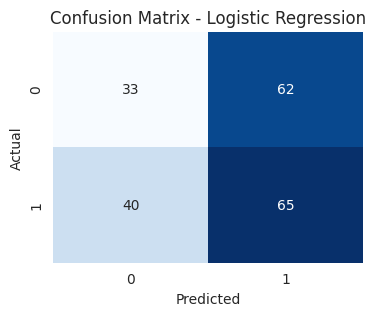

Model: KNN
Accuracy: 0.4800
ROC-AUC: 0.4886

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.40      0.42        95
           1       0.50      0.55      0.53       105

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.47       200
weighted avg       0.48      0.48      0.48       200



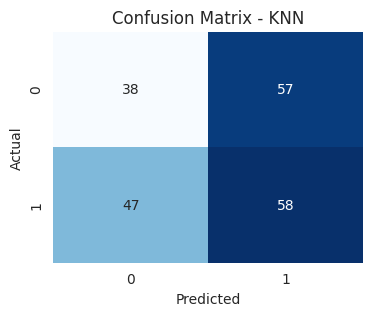

Model: Decision Tree
Accuracy: 0.4900
ROC-AUC: 0.4887

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.46      0.46        95
           1       0.51      0.51      0.51       105

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200



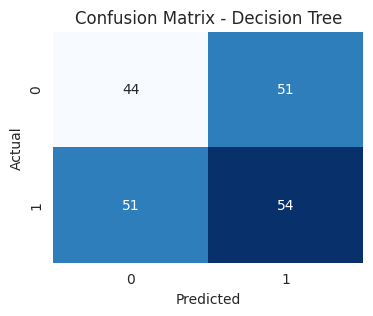

Model: Random Forest
Accuracy: 0.5500
ROC-AUC: 0.5581

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.48      0.51        95
           1       0.57      0.61      0.59       105

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.55      0.55      0.55       200



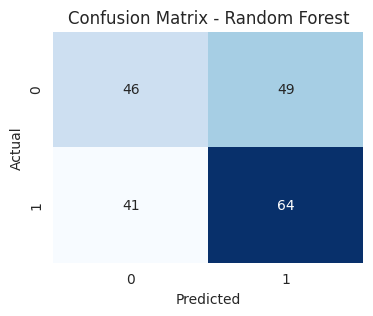

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_eng_scaled, y_train)
    y_val_pred = model.predict(X_val_eng_scaled)
    y_val_prob = model.predict_proba(X_val_eng_scaled)[:, 1]
    acc = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_prob)
    cm = confusion_matrix(y_val, y_val_pred)
    cr = classification_report(y_val, y_val_pred, output_dict=False)
    results[name] = {"accuracy": acc, "auc": auc, "cm": cm, "report": cr}

    print(f"Model: {name}")

    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print("\nClassification Report:\n", cr)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Model: CatBoost
Accuracy: 0.5650

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.45      0.50        95
           1       0.57      0.67      0.62       105

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200



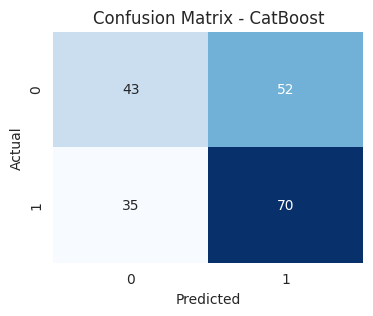

Model: XGBoost
Accuracy: 0.5450

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.51      0.51        95
           1       0.56      0.58      0.57       105

    accuracy                           0.55       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.55      0.54       200



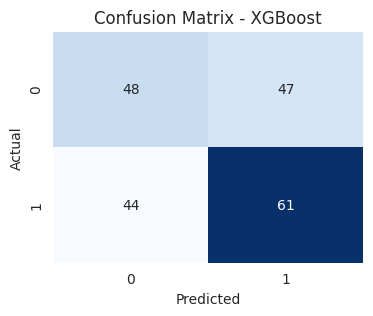

Model: AdaBoost
Accuracy: 0.5200

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        95
           1       0.52      0.99      0.68       105

    accuracy                           0.52       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.27      0.52      0.36       200



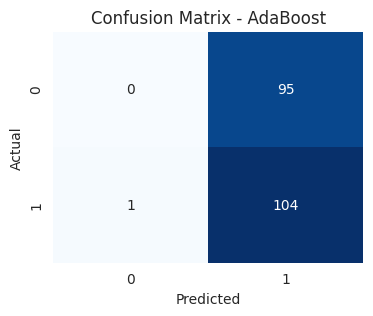

In [29]:
!pip install catboost
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

models = {
    "CatBoost": CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=0, random_seed=42),
    "XGBoost": XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_eng_scaled, y_train)
    y_val_pred = model.predict(X_val_eng_scaled)
    acc = accuracy_score(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)
    cr = classification_report(y_val, y_val_pred, output_dict=False)
    results[name] = {"accuracy": acc, "cm": cm, "report": cr}

    print(f"Model: {name}")

    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", cr)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
ANN Model Performance
Validation Accuracy: 0.5100

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.45      0.47        95
           1       0.53      0.56      0.55       105

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200



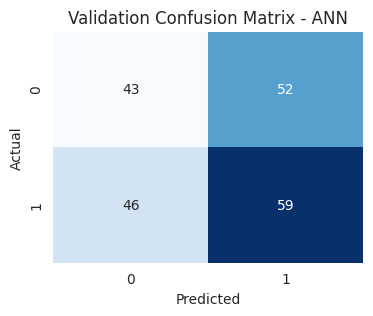

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_eng_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_eng_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_val_eng_scaled, y_val), verbose=0)

y_val_pred_prob = model.predict(X_val_eng_scaled)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

val_acc = accuracy_score(y_val, y_val_pred)
val_cm = confusion_matrix(y_val, y_val_pred)
val_cr = classification_report(y_val, y_val_pred, output_dict=False)


print(f"ANN Model Performance")

print(f"Validation Accuracy: {val_acc:.4f}")
print("\nValidation Classification Report:\n", val_cr)

plt.figure(figsize=(4,3))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Validation Confusion Matrix - ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Using transformer based model

In [34]:
from sklearn.preprocessing import StandardScaler


cat_cols = ['Gender_Encoded', 'Promotion_Response_Encoded', 'Email_Opt_In_Encoded']

num_cols = [col for col in X_train.columns if col not in cat_cols]

# Scale numerical columns
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_val_num = scaler.transform(X_val[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# Get categorical arrays
X_train_cat = X_train[cat_cols].values
X_val_cat = X_val[cat_cols].values
X_test_cat = X_test[cat_cols].values

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)



Numerical columns: ['Age', 'Annual_Income', 'Total_Spend', 'Years_as_Customer', 'Num_of_Purchases', 'Average_Transaction_Amount', 'Num_of_Returns', 'Num_of_Support_Contacts', 'Satisfaction_Score', 'Last_Purchase_Days_Ago']
Categorical columns: ['Gender_Encoded', 'Promotion_Response_Encoded', 'Email_Opt_In_Encoded']


Epoch 1, Validation Accuracy: 0.5550
Epoch 2, Validation Accuracy: 0.5250
Epoch 3, Validation Accuracy: 0.5300
Epoch 4, Validation Accuracy: 0.5300
Epoch 5, Validation Accuracy: 0.5350
Epoch 6, Validation Accuracy: 0.4850
Epoch 7, Validation Accuracy: 0.5550
Epoch 8, Validation Accuracy: 0.5250
Epoch 9, Validation Accuracy: 0.4550
Epoch 10, Validation Accuracy: 0.5100
Epoch 11, Validation Accuracy: 0.5000
Epoch 12, Validation Accuracy: 0.5150
Epoch 13, Validation Accuracy: 0.5400
Epoch 14, Validation Accuracy: 0.4750
Epoch 15, Validation Accuracy: 0.4550
Epoch 16, Validation Accuracy: 0.4850
Epoch 17, Validation Accuracy: 0.4950
Epoch 18, Validation Accuracy: 0.5200
Epoch 19, Validation Accuracy: 0.5100
Epoch 20, Validation Accuracy: 0.4850

Classification Report:
               precision    recall  f1-score   support

         0.0       0.44      0.34      0.38        95
         1.0       0.51      0.62      0.56       105

    accuracy                           0.48       200
   mac

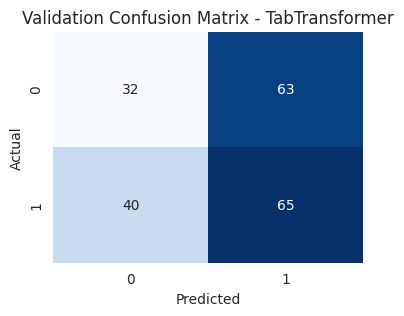

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Dataset class

class ChurnDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]


# TabTransformer model

class TabTransformer(nn.Module):
    def __init__(self, num_numeric, cat_cardinalities, embed_dim=32, n_heads=4, depth=2, mlp_hidden=64, dropout=0.2):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(card, embed_dim) for card in cat_cardinalities])
        self.transformer_layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dropout=dropout) for _ in range(depth)])
        self.num_norm = nn.BatchNorm1d(num_numeric)
        self.mlp = nn.Sequential(
            nn.Linear(num_numeric + len(cat_cardinalities)*embed_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x_num, x_cat):
        cat_embeds = [emb(x_cat[:,i]) for i, emb in enumerate(self.embeddings)]
        cat_embeds = torch.stack(cat_embeds, dim=1)
        for layer in self.transformer_layers:
            cat_embeds = layer(cat_embeds)
        cat_embeds = cat_embeds.flatten(start_dim=1)
        x_num = self.num_norm(x_num)
        x = torch.cat([x_num, cat_embeds], dim=1)
        return self.mlp(x)



y_train_array = y_train.values if hasattr(y_train, "values") else np.array(y_train)
y_val_array = y_val.values if hasattr(y_val, "values") else np.array(y_val)


# Prepare datasets & loaders

train_dataset = ChurnDataset(X_train_num, X_train_cat, y_train_array)
val_dataset = ChurnDataset(X_val_num, X_val_cat, y_val_array)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Model, loss, optimizer

cat_cardinalities = [int(X_train_cat[:,i].max()+1) for i in range(X_train_cat.shape[1])]
model = TabTransformer(num_numeric=X_train_num.shape[1], cat_cardinalities=cat_cardinalities)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training loop

for epoch in range(20):
    model.train()
    for x_num, x_cat, y in train_loader:
        x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        output = model(x_num, x_cat)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for x_num, x_cat, y in val_loader:
            x_num, x_cat = x_num.to(device), x_cat.to(device)
            output = model(x_num, x_cat)
            val_preds.extend((output.cpu().numpy() > 0.5).astype(int))
            val_true.extend(y.numpy())
    val_acc = accuracy_score(val_true, val_preds)
    print(f"Epoch {epoch+1}, Validation Accuracy: {val_acc:.4f}")


# Final evaluation: confusion matrix & classification report

cm = confusion_matrix(val_true, val_preds)
cr = classification_report(val_true, val_preds)
print("\nClassification Report:\n", cr)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Validation Confusion Matrix - TabTransformer")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Since Catboost is the best model till now , lets combine train and val set and test in test set

Best parameters: {'iterations': 401, 'depth': 5, 'learning_rate': 0.011281502199482686, 'l2_leaf_reg': 1.632324761037347}
Best internal validation accuracy: 0.60625
0:	learn: 0.6927218	total: 1.96ms	remaining: 784ms
1:	learn: 0.6921109	total: 4.25ms	remaining: 848ms
2:	learn: 0.6916559	total: 6.04ms	remaining: 801ms
3:	learn: 0.6908118	total: 7.95ms	remaining: 789ms
4:	learn: 0.6903822	total: 10.1ms	remaining: 801ms
5:	learn: 0.6899526	total: 12.2ms	remaining: 803ms
6:	learn: 0.6892260	total: 15.3ms	remaining: 861ms
7:	learn: 0.6883675	total: 17.4ms	remaining: 854ms
8:	learn: 0.6879561	total: 19.2ms	remaining: 834ms
9:	learn: 0.6874840	total: 21.3ms	remaining: 834ms
10:	learn: 0.6867180	total: 23.1ms	remaining: 819ms
11:	learn: 0.6861633	total: 25.1ms	remaining: 812ms
12:	learn: 0.6851817	total: 27.2ms	remaining: 812ms
13:	learn: 0.6844559	total: 30.2ms	remaining: 835ms
14:	learn: 0.6837260	total: 31.8ms	remaining: 820ms
15:	learn: 0.6830276	total: 34ms	remaining: 819ms
16:	learn: 0.68

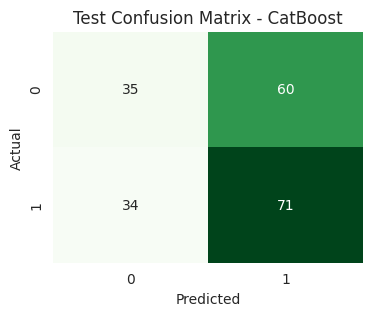

In [39]:
# Combine train + validation sets
X_train_val_scaled = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train_array, y_val_array])
X_test_scaled_np = np.array(X_test_scaled)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': 42,
        'eval_metric': 'Accuracy',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    # For Optuna, we use cross-validation internally on train_val
    # Simple split: last 20% of train_val as internal validation
    n_val = int(0.2 * len(X_train_val_scaled))
    model.fit(X_train_val_scaled[:-n_val], y_train_val[:-n_val])

    y_pred_val = model.predict(X_train_val_scaled[-n_val:])
    acc = accuracy_score(y_train_val[-n_val:], y_pred_val)

    return acc

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best internal validation accuracy:", study.best_value)

# Train final model on full train+val set with best params
best_params = study.best_params
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train_val_scaled, y_train_val)

# Predict on test set
y_test_pred = final_model.predict(X_test_scaled_np)

# Evaluation
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_acc:.4f}")

cr = classification_report(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
print("\nClassification Report:\n", cr)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Test Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
